In [8]:
import yfinance as yf
import pandas as pandas
import numpy as np

In [7]:
# Stocks investigated
tickers = ['PSN', 'GSK', 'BARC.L', 'VOD', 'JD.L']

# Download the above tickers from yfinance
data = yf.download(tickers, start = "2023-01-01", end = "2024-12-15")

# preview of data
data['Adj Close'].head()

# Calculate Daily Returns
returns = data['Adj Close'].pct_change().dropna()
returns.head()

[*********************100%%**********************]  5 of 5 completed


,BARC.L,GSK,JD.L,PSN,VOD
Date,,,,,
2023-01-04,0.027384,-0.007368,0.042791,-0.005971,0.023166
2023-01-05,0.025821,-0.015701,0.030684,-0.024917,-0.001887
2023-01-06,-0.001856,0.012761,0.022597,0.006388,0.016068
2023-01-09,0.003021,-0.011168,-0.013679,-0.015643,-0.000930
2023-01-10,-0.005909,0.006082,0.002134,0.009903,0.000000


# Calculating Historical VaR 

So the concept of historical VaR is to use the past returns in order to calculate the maximum expected loss at a certain confidence level

The equation used to retrieve this is :


Historical VaR = Percentile of Returns at (1 - Confidence Level) * 100


In [1]:
def historical_var(returns, confidence_level=0.95):
    """
    To calculate VaR we need:
    - the Asset or portfolio returns
    - the confidence level we are using for the VaR calculation
   
    What is returned is the VaR 
    """

    var_value = np.percentile(returns, (1-confidence_level) * 100)
    return var_value

In [16]:
# We can now test the Historical VaR for the tickers above

confidence_level = 0.95
psn_h_var = historical_var(returns['PSN'], confidence_level)
print(f"Historical VaR for PSN (95%): {psn_h_var:.4%}")

gsk_h_var = historical_var(returns['GSK'], confidence_level)
print(f"Historical VaR for GSK (95%): {gsk_h_var:.4%}")

barc_h_var = historical_var(returns['BARC.L'], confidence_level)
print(f"Historical VaR for BARC.L (95%): {barc_h_var:.4%}")

vod_h_var = historical_var(returns['VOD'], confidence_level)
print(f"Historical VaR for VOD (95%): {vod_h_var:.4%}")

Historical VaR for PSN (95%): -1.9747%
Historical VaR for GSK (95%): -1.9566%
Historical VaR for BARC.L (95%): -2.6511%
Historical VaR for VOD (95%): -2.4863%


# Calculating Parametric VaR (Variance-Covariance Method)

Parametric VaR a statistical approach used to estimate the potential loss in the value of a portfolio over a given time horizon, assuming that asset returns are normally distributed. It uses the mean and the standard deviation.


Parametric VaR = mu + sigma*Z
Here:
mu = mean return
sigma = Standard deviation of returns
Z = Inverse of normal CDF for the confidence level



In [14]:
from scipy.stats import norm

def parametric_var(returns, confidence_level = 0.95):
    """
    To calculate the Parametric VaR (Variance-Covariance)
    We assume that the returns have a normal distribution
    """

    mean_return = np.mean(returns)
    std_dev = np.std(returns)
    z_score = norm.ppf(1 - confidence_level)

    var_value = mean_return + z_score * std_dev
    return var_value

In [15]:
# We can now test the parametric VaR for the tickers above

confidence_level = 0.95
psn_h_var = parametric_var(returns['PSN'], confidence_level)
print(f"parametric VaR for PSN (95%): {psn_h_var:.4%}")

gsk_h_var = parametric_var(returns['GSK'], confidence_level)
print(f"parametric VaR for GSK (95%): {gsk_h_var:.4%}")

barc_h_var = parametric_var(returns['BARC.L'], confidence_level)
print(f"parametric VaR for BARC.L (95%): {barc_h_var:.4%}")

vod_h_var = parametric_var(returns['VOD'], confidence_level)
print(f"parametric VaR for VOD (95%): {vod_h_var:.4%}")

parametric VaR for PSN (95%): -2.6299%
parametric VaR for GSK (95%): -2.0687%
parametric VaR for BARC.L (95%): -2.8879%
parametric VaR for VOD (95%): -2.6769%


In [17]:
def monte_carlo_var(returns, confidence_level=0.95, simulations=100000):
    """
    Creating 100,000 monte carlo simulations to gather VaR
    """
    mean_return = np.mean(returns)
    std_dev = np.std(returns)
    
    simulated_returns = np.random.normal(mean_return, std_dev, simulations)
    var_value = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    return var_value

In [19]:
# We can now test the expected_shortfall VaR for the tickers above

confidence_level = 0.95
psn_h_var = expected_shortfall_var(returns['PSN'], confidence_level)
print(f"expected_shortfall VaR for PSN (95%): {psn_h_var:.4%}")

gsk_h_var = expected_shortfall_var(returns['GSK'], confidence_level)
print(f"expected_shortfall VaR for GSK (95%): {gsk_h_var:.4%}")

barc_h_var = expected_shortfall_var(returns['BARC.L'], confidence_level)
print(f"expected_shortfall VaR for BARC.L (95%): {barc_h_var:.4%}")

vod_h_var = expected_shortfall_var(returns['VOD'], confidence_level)
print(f"expected_shortfall VaR for VOD (95%): {vod_h_var:.4%}")

monte_carlo VaR for PSN (95%): -2.6373%
monte_carlo VaR for GSK (95%): -2.0645%
monte_carlo VaR for BARC.L (95%): -2.9011%
monte_carlo VaR for VOD (95%): -2.6684%


Expected Shortfall also know as Conditional Value at Risk

ES goes one step further than VaR, instead of giving a threshold, it gives the average loss beyond that threshold. So it paints a picture of extreme events, where the VaR limit is exceeded.

In [20]:
def expected_shortfall(returns, confidence_level=0.95):
    """
    Calculates the ES AKA the CVaR
    """
    var_value = historical_var(returns, confidence_level)
    # Here returns that are less than the var_value are taken and the average is found
    es_value = returns[returns <= var_value].mean()
    return es_value

In [21]:
# We can now test the expected_shortfall VaR for the tickers above

confidence_level = 0.95
psn_es_cvar = expected_shortfall(returns['PSN'], confidence_level)
print(f"expected_shortfall VaR for PSN (95%): {psn_es_cvar:.4%}")

gsk_es_cvar = expected_shortfall(returns['GSK'], confidence_level)
print(f"expected_shortfall VaR for GSK (95%): {gsk_es_cvar:.4%}")

barc_es_cvar = expected_shortfall(returns['BARC.L'], confidence_level)
print(f"expected_shortfall VaR for BARC.L (95%): {barc_es_cvar:.4%}")

vod_es_cvar = expected_shortfall(returns['VOD'], confidence_level)
print(f"expected_shortfall VaR for VOD (95%): {vod_es_cvar:.4%}")

expected_shortfall VaR for PSN (95%): -2.9410%
expected_shortfall VaR for GSK (95%): -2.7360%
expected_shortfall VaR for BARC.L (95%): -4.1193%
expected_shortfall VaR for VOD (95%): -3.6953%


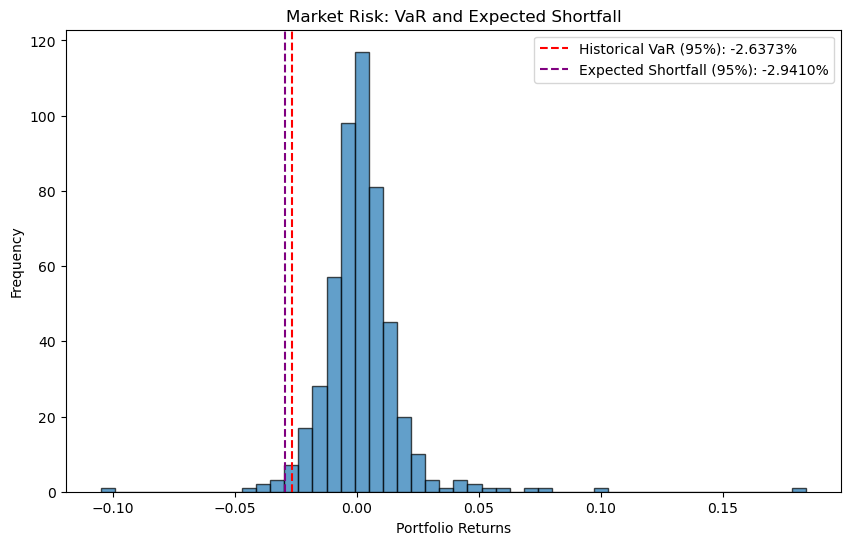

In [23]:
import matplotlib.pyplot as plt

# Plot Histogram of Returns
plt.figure(figsize=(10, 6))
plt.hist(returns["PSN"], bins=50, edgecolor='k', alpha=0.7)
plt.axvline(psn_h_var, color='r', linestyle='--', label=f'Historical VaR (95%): {psn_h_var:.4%}')
plt.axvline(psn_es_cvar, color='purple', linestyle='--', label=f'Expected Shortfall (95%): {psn_es_cvar:.4%}')
plt.title("Market Risk: VaR and Expected Shortfall")
plt.xlabel("Portfolio Returns")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Next Steps:
	1.	Add Portfolio-Level VaR (Multi-Asset).
	2.	Extend to Time-Varying Volatility Models (GARCH).
	3.	Implement Backtesting Framework for validation.
	4.	Create Professional Documentation & Report.

Would you like deeper dives into Portfolio VaR, Risk Factor Modeling, or Time-Series Forecasting next? 🚀